# Quickstart

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/frannerin/AlloViz/HEAD?labpath=notebooks%2Fquickstart.ipynb)

In [1]:
import AlloViz
import matplotlib.pyplot as plt
import pandas as pd
import os 
import glob
from natsort import natsorted

---
# DATA

In [2]:
# Orthosteric residues
ortho = [181, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 262]


# DES4799 domminant binding site residues
DES4799 = [80, 205, 208, 209]


# Allosteric residues identified by Sunesis
sunesis = [188, 189, 192, 193, 196, 197, 200, 276, 277, 280, 281]

In [3]:
trdir0 = "/Users/camillacaprai/AlloViz/DESRES/traj0"

# List containing all the trajectories obtained by truncating the PTP1B:DES-4799 at increasing lengths from 10 ns to 10 μs
tr0 = natsorted([os.path.join(trdir0, filename) 
             for filename in os.listdir(trdir0) 
             if filename.endswith(".dcd")])

---
# FUNCTIONS

In [4]:
def mybtwn(trajs: str, 
           pkgs="pytraj_CA",
           pdb = "/Users/camillacaprai/AlloViz/DESRES/processed/DESRES-Trajectory_jcim2023b-DES4799-no-water.pdb", 
           path = None, 
           filterings = "Spatially_distant", 
           elements = ["edges", "nodes"], 
           metrics = ["btw", "cfb"]):
    """
    System setup, network calculation, filtering and analysis.
    Create and save as csv the "btwn" dataframe with the metrics values for each reasidue.
    """
    
    if not os.getcwd() == "/Users/camillacaprai/AlloViz/notebooks":
        os.chdir("/Users/camillacaprai/AlloViz/notebooks")
        
    run_folder = os.path.join(os.getcwd(), f'run_{pkgs}.{filterings}')
    if os.path.exists(run_folder):
        os.chdir(run_folder)
    else:
        os.makedirs(run_folder)
        os.chdir(run_folder)  
    
    if path == None:
        trajs_folder = os.path.join(os.getcwd(), os.path.splitext(os.path.basename(trajs))[-2])
        if not os.path.exists(trajs_folder):
            os.makedirs(trajs_folder)
        path = trajs_folder
    
    system = AlloViz.Protein(pdb=pdb, trajs=trajs, path=path)
    
    system.calculate(pkgs=pkgs)
    system.filter(filterings=filterings)
    system.analyze(elements=elements, metrics=metrics)
    
    system_pkg = getattr(system, pkgs)
    system_pkg_filtering = getattr(system_pkg, filterings)
    btwn = system_pkg_filtering.nodes
    
    btwn['respos'] = btwn.index
    btwn['resid'] = btwn['respos'].str.split(':').str[0]
    btwn['resnum'] = btwn['respos'].str.split(':').str[1].astype(int)
    btwn.index = btwn['resnum']
    btwn = btwn.sort_index()
    
    btwn.to_csv(os.path.join(path, f'btwn_{path.split("/")[-1]}.csv'))
    
    os.chdir("..")
    
    return btwn, path, pkgs, filterings, run_folder

In [5]:
def myscatter(trajs,
              save = True, 
              pkgs="pytraj_CA",
              filterings="Spatially_distant",
              x = "btw", 
              y = "cfb", 
              xlab = "Betweenness", 
              ylab = "Current Flow Betweenness"):
    """
    Plot of the two chosen metrics.
    """
    
    
    btwn, path, pkgs, filterings, run_folder = mybtwn(trajs, pkgs=pkgs, filterings=filterings)
    
    run_folder = os.path.join(os.getcwd(), f'run_{pkgs}.{filterings}')
    os.chdir(run_folder)
    
    orthodf = btwn[btwn['resnum'].isin(ortho)]
    DES4799df = btwn[btwn['resnum'].isin(DES4799)]
    sunesisdf = btwn[btwn['resnum'].isin(sunesis)]
    
    plt.plot(btwn[x], btwn[y], 'o', alpha = 0.3, color = 'gray')
    plt.plot(orthodf[x], orthodf[y], 'o', label = 'Orthosteric Site')
    plt.plot(DES4799df[x], DES4799df[y], 'o', label = 'DES-4799 Binding Residues')
    plt.plot(sunesisdf[x], sunesisdf[y], 'o', label = 'Sunesis Allosteric Residues')
    
    #p10-p90
    #plt.xlim(-0.0013, 0.0307)
    #plt.ylim(0.00175, 0.0099)
    
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.legend()
    
    if not save:
        plt.show()
    else:
        if path:
            plt.savefig(os.path.join(path, f'{path.split("/")[-1]}.png'), dpi=400)
        else:
            plt.savefig(f'{path.split("/")[-1]}.png', dpi=400)
            
    plt.close()
    
    os.chdir("..")

In [6]:
def btwndf_fun(btwndir):
    """
    Read the csv file and return the corresponding dataframe.
    Add an additional column storing the length of the trajectory.
    """
    btwnl = natsorted([os.path.join(btwndir, filename) 
                   for filename in os.listdir(btwndir) 
                   if filename.endswith(".csv")])

    btwndf = pd.DataFrame()
    for filename in btwnl:
        df = pd.read_csv(filename)
        df['length'] = int(os.path.basename(filename).split(".")[0].split("_")[-1].split("p")[-1])
        btwndf = pd.concat([btwndf, df])
        btwndf.drop('resnum.1', axis=1, inplace=True)
        
    return btwndf

In [7]:
def resplot(btwndf, 
            save = True, 
            despos = 'SER:205',
            orthopos = 'SER:216', 
            allopos ='PHE:280'): 
    """
    Plot the tendency of the two metrics over the different trajectory lengths for the three residues, each representative of one of the groups.
    """

    
    fig, ax = plt.subplots(2, figsize=(5,5))

    ortholabel = orthopos.replace(":", " ").capitalize()
    allolabel = allopos.replace(":", " ").capitalize()
    deslabel = despos.replace(":", " ").capitalize()
    
    ax[0].semilogx(btwndf['length'][btwndf['respos'] == orthopos], btwndf['cfb'][btwndf['respos'] == orthopos], 'o-', markersize = 3, label = ortholabel, color = 'tab:blue')
    ax[0].semilogx(btwndf['length'][btwndf['respos'] == allopos], btwndf['cfb'][btwndf['respos'] == allopos], 'o-', markersize = 3, label = allolabel, color = 'tab:green')
    ax[0].semilogx(btwndf['length'][btwndf['respos'] == despos], btwndf['cfb'][btwndf['respos'] == despos], 'o-', markersize = 3, label = deslabel, color = 'tab:orange')
    ax[0].set_ylim(0.0, 0.01)
    ax[0].set_ylabel('Current Flow Betweenness')
    ax[0].xaxis.set_ticklabels([])
    ax[0].tick_params(bottom = False)
    ax[0].minorticks_off()


    ax[1].semilogx(btwndf['length'][btwndf['respos'] == orthopos], btwndf['btw'][btwndf['respos'] == orthopos], 'o-', markersize = 3, label = ortholabel, color = 'tab:blue')
    ax[1].semilogx(btwndf['length'][btwndf['respos'] == allopos], btwndf['btw'][btwndf['respos'] == allopos], 'o-', markersize = 3, label = allolabel, color = 'tab:green')
    ax[1].semilogx(btwndf['length'][btwndf['respos'] == despos], btwndf['cfb'][btwndf['respos'] == despos], 'o-', markersize = 3, label = deslabel, color = 'tab:orange')
    ax[0].set_ylim(0.0, 0.01)
    ax[1].set_xlabel('Trajectory Length (ns)')
    ax[1].set_ylabel('Betweenness')

    ax[0].legend()
    ax[1].legend()
    plt.tight_layout()
    
    if not save:
        plt.show()
    else:
        plt.savefig(f'{orthopos}-{allopos}-{despos}'.replace(":", ""), dpi=400)
            
    plt.close()

---
---

# Betweenness and Current Flow Betweenness  of PTP1B Residues 

Betweenness centrality and current flow betweenness centrality for all of the protein’s residues, computed throughout of the first 10 μs of the PTP1B:DES-4799 trajectory. Residues involved in the orthosteric and
allosteric sites are separated along both axes in two distinct groups. Furthermore, residues identified by <a href="https://www.nature.com/articles/nsmb803">Wiesman et al.</a> (green, Sunesis) and <a href="https://pubs.acs.org/doi/10.1021/acs.jcim.3c00236">Greisman et al.</a> (orange, DES-4799), both allosteric but belonging to two distinct sites, cluster together suggesting that the metrics are related to allostery rather than specific
residue positions. 

The analysis on the full 100 μs trajectory provides essentially the same results.

pytraj_CA
adding raw data of pytraj_CA for /Users/camillacaprai/AlloViz/notebooks/run_pytraj_CA.Spatially_distant/p10000/data/protein.pdb:  ['/Users/camillacaprai/AlloViz/notebooks/run_pytraj_CA.Spatially_distant/p10000/data/pytraj_CA/raw/1.pq']
Please, make sure to correctly cite the package used to compute the network: pytraj (https://github.com/Amber-MD/pytraj#citation)
adding analyzed edges <AlloViz.Wrappers.pytraj_w.pytraj_CA object at 0x18d213250> Spatially_distant data of for /Users/camillacaprai/AlloViz/notebooks/run_pytraj_CA.Spatially_distant/p10000/data/protein.pdb
adding analyzed nodes <AlloViz.Wrappers.pytraj_w.pytraj_CA object at 0x18d213250> Spatially_distant data of for /Users/camillacaprai/AlloViz/notebooks/run_pytraj_CA.Spatially_distant/p10000/data/protein.pdb


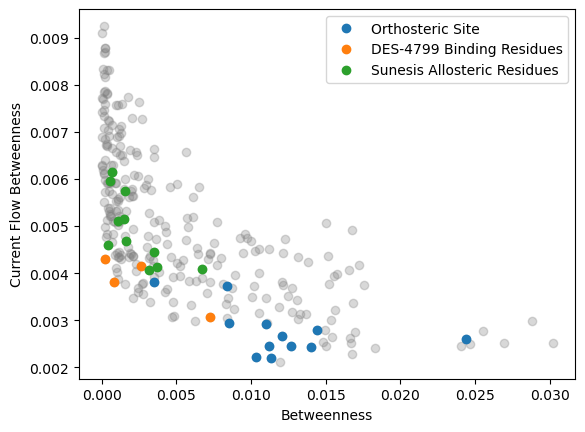

In [8]:
myscatter(tr0[-1], save = False)

----

# Betweenness and Current Flow Betweenness Tendency Over Time

The plots below show the tendency of the two centrality metrics over time for three different residues, each representative of one of the three sets:
- Orthosteric residue in blue;
- DES-4799 binding residue, from <a href="https://pubs.acs.org/doi/10.1021/acs.jcim.3c00236">Greisman et al.</a>, in orange;
- Sunesis allosteric residue, from <a href="https://www.nature.com/articles/nsmb803">Wiesman et al.</a>, in green. 

Each dot reprents a different simulation length, obtained by truncating the trajectory at increasing lengths from 10 ns to 10 μs, in orderto study the convergence of the two metrics with respect to increasing trajectory lengths

For both metrics, convergence is achieved approximately at 200 ns.

In [9]:
btwndf0 = btwndf_fun("/Users/camillacaprai/AlloViz/notebooks/tr_0/allbtwn")

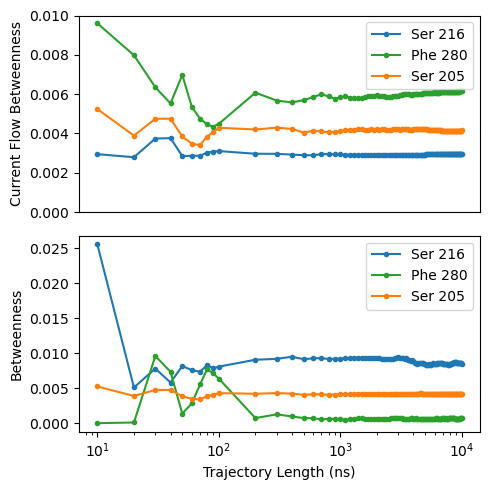

In [10]:
# PHE:280-SER:216-SER:205

resplot(btwndf0, save = False)

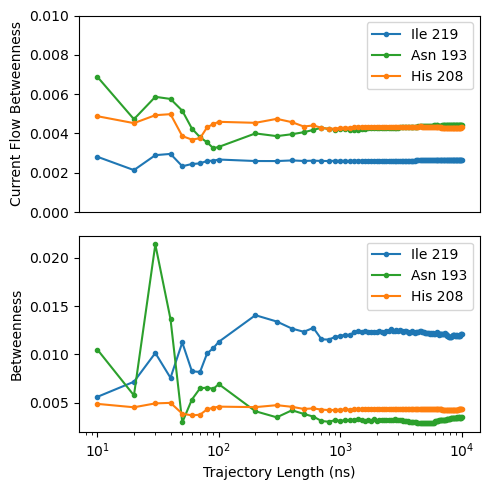

In [11]:
# ASN:193-ILE:219-HIS:208

resplot(btwndf0, orthopos = 'ILE:219', allopos = 'ASN:193', despos = 'HIS:208', save = False)